In [42]:
library(tidyverse)
library(ggplot2)
library(scales)
library(tikzDevice)

In [43]:
# from https://stackoverflow.com/questions/30179442/plotting-minor-breaks-on-a-log-scale-with-ggplot
log_breaks = function(maj, radix=10) {
  function(x) {
    minx         = floor(min(logb(x,radix), na.rm=T)) - 1
    maxx         = ceiling(max(logb(x,radix), na.rm=T)) + 1
    n_major      = maxx - minx + 1
    major_breaks = seq(minx, maxx, by=1)
    if (maj) {
      breaks = major_breaks
    } else {
      steps = logb(1:(radix-1),radix)
      breaks = rep(steps, times=n_major) +
               rep(major_breaks, each=radix-1)
    }
    radix^breaks
  }
}
scale_x_log_eng = function(..., radix=10) {
  scale_x_continuous(...,
                     trans=log_trans(radix),
                     breaks=log_breaks(TRUE, radix),
                     minor_breaks=log_breaks(FALSE, radix))
}
scale_y_log_eng = function(..., radix=10) {
  scale_y_continuous(...,
                     trans=log_trans(radix),
                     breaks=log_breaks(TRUE, radix),
                     minor_breaks=log_breaks(FALSE, radix))
}

tikz_file <- function(filename, plot=last_plot(), width=7, height=7) {
        p = plot
        # p = plot + theme(text = element_text(size=16, family="CM Roman"),
        #                  axis.title.x = element_text(face="italic"),
        #                  axis.title.y = element_text(face="bold"))
        # f = paste(tools::file_path_sans_ext(filename), ".eps", sep="")
        # postscript(f, family="CM Roman", width = width, height = height, useKerning=TRUE)
        # file = set.file.extension(filename, extension=".png")
        file = filename
        print(sprintf("Writing to %s", file))
        # png(file=file)
        tikz(file = filename, width = width, height = height)
        print(plot)
        dev.off()
}

In [44]:
read_problem = function(filepath) {
    dir = gsub("\\..*$", "", basename(dirname(filepath)))
    robust = grepl("robust", filepath)
    read_csv(filepath, col_types = cols()) %>% mutate(bal=dir, robust=robust)
}
read_problems = function(filepat, solvername) {
    bind_rows(lapply(Sys.glob(file.path("../ba-problems/*.problem", filepat)), read_problem)) %>%
    mutate(solver = solvername)
}

In [45]:
ceres =
bind_rows( read_problems("ceres_benchmark_pbjacobi.csv", "Point Block Jacobi")
         , read_problems("ceres_benchmark_pbjacobi_eta01.csv", "Point Block Jacobi")
         , read_problems("ceres_benchmark_pbjacobi_robust.csv", "Point Block Jacobi")
         , read_problems("ceres_benchmark_pbjacobi_robust01.csv", "Point Block Jacobi")
         , read_problems("ceres_benchmark_visibility.csv", "Visibility")
         , read_problems("ceres_benchmark_visibility_eta01.csv", "Visibility")
         , read_problems("ceres_benchmark_visibility_robust.csv", "Visibility")
         , read_problems("ceres_benchmark_visibility_robust01.csv", "Visibility")
         , read_problems("ceres_benchmark_visibility_tridiagonal.csv", "Visibility Tridiagonal")
         , read_problems("ceres_benchmark_visibility_tridiagonal_eta01.csv", "Visibility Tridiagonal")
         , read_problems("ceres_benchmark_visibility_tridiagonal_robust.csv", "Visibility Tridiagonal")
         , read_problems("ceres_benchmark_multigrid.csv", "Multigrid")
         , read_problems("ceres_benchmark_multigrid_eta01.csv", "Multigrid")
         , read_problems("ceres_benchmark_multigrid_robust.csv", "Multigrid")
         , read_problems("ceres_benchmark_multigrid_robust01.csv", "Multigrid")
         # , read_problems("multigrid_benchmark_smooth.csv", "SA Multigrid")
         )
ceres = ceres %>% group_by(bal, solver, eta, robust) %>%
  mutate(ctime = cumsum(setup_time)+cumsum(solve_time), costmin=cummin(cost))

In [46]:
# Filter rows so it is as if we solved all problem to the same tolerance
mincost = ceres %>% dplyr::filter(is.element(solver, c("Multigrid", "Visbility Tridiagonal", "Visibility", "Point Block Jacobi"))) %>%
  group_by(bal, solver, eta, robust) %>% summarize(mincost=min(cost))
maxmincost = mincost %>% group_by(bal, eta, robust) %>% summarize(maxmincost=max(mincost))
ceres = inner_join(ceres, maxmincost, by=c("bal", "eta", "robust"))
#TODO: this might keep later rows if cost goes back up
d_sametol = ceres %>% group_by(bal, solver, eta, robust) %>%
    group_modify(~ .x[.x$problem <= min(.x$problem[.x$cost <= .x$maxmincost]),])

Warning message in min(.x$problem[.x$cost <= .x$maxmincost]):
“no non-missing arguments to min; returning Inf”
Warning message in min(.x$problem[.x$cost <= .x$maxmincost]):
“no non-missing arguments to min; returning Inf”
Warning message in min(.x$problem[.x$cost <= .x$maxmincost]):
“no non-missing arguments to min; returning Inf”
Warning message in min(.x$problem[.x$cost <= .x$maxmincost]):
“no non-missing arguments to min; returning Inf”


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


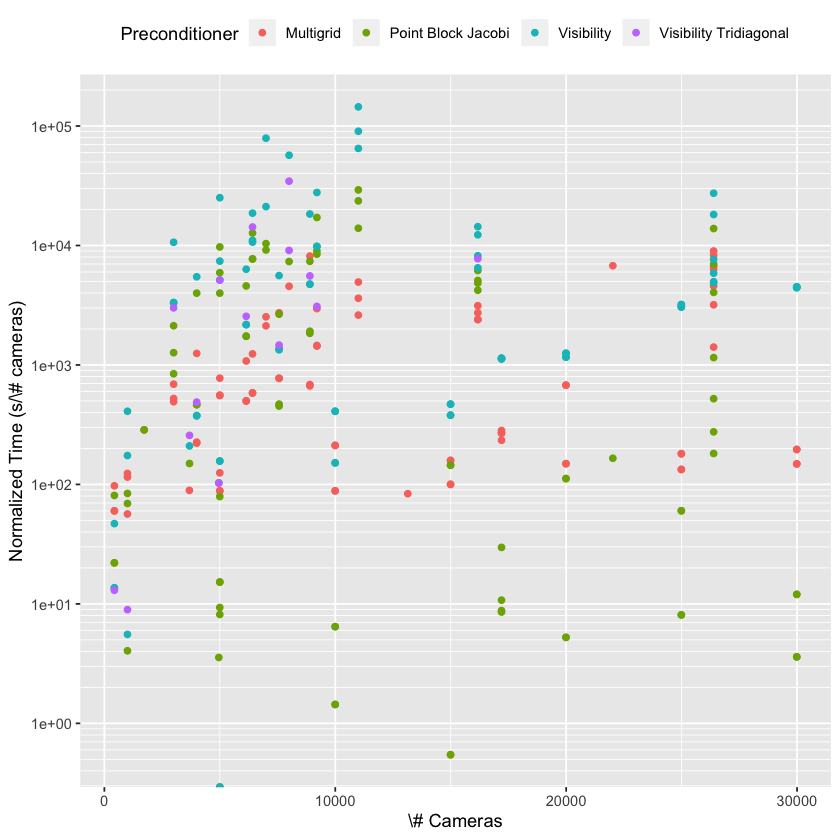

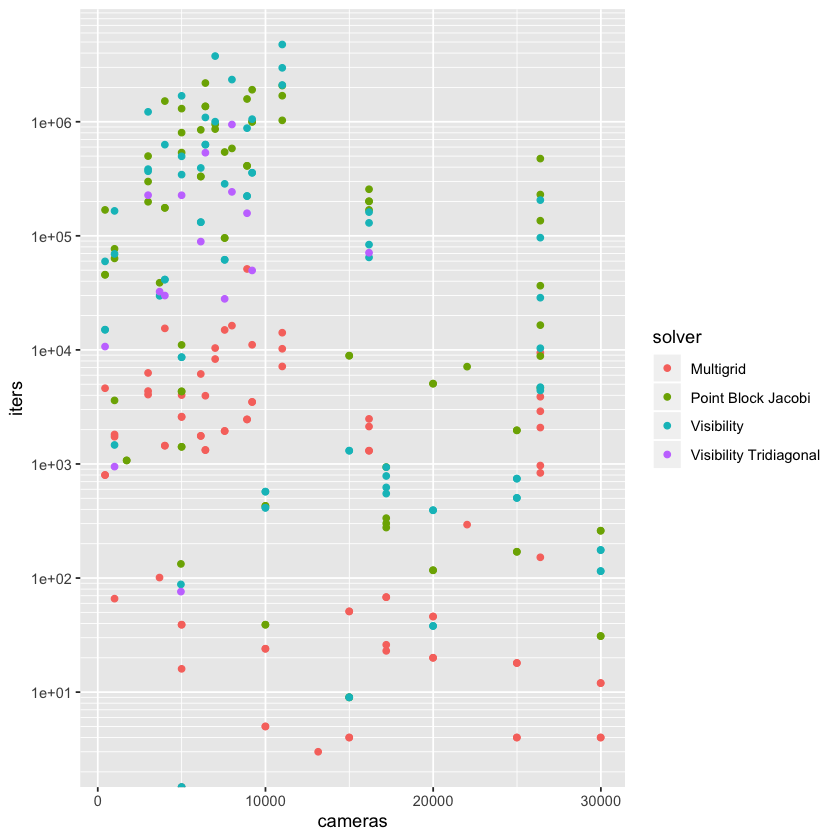

Warning message:
“Removed 10 rows containing missing values (geom_point).”


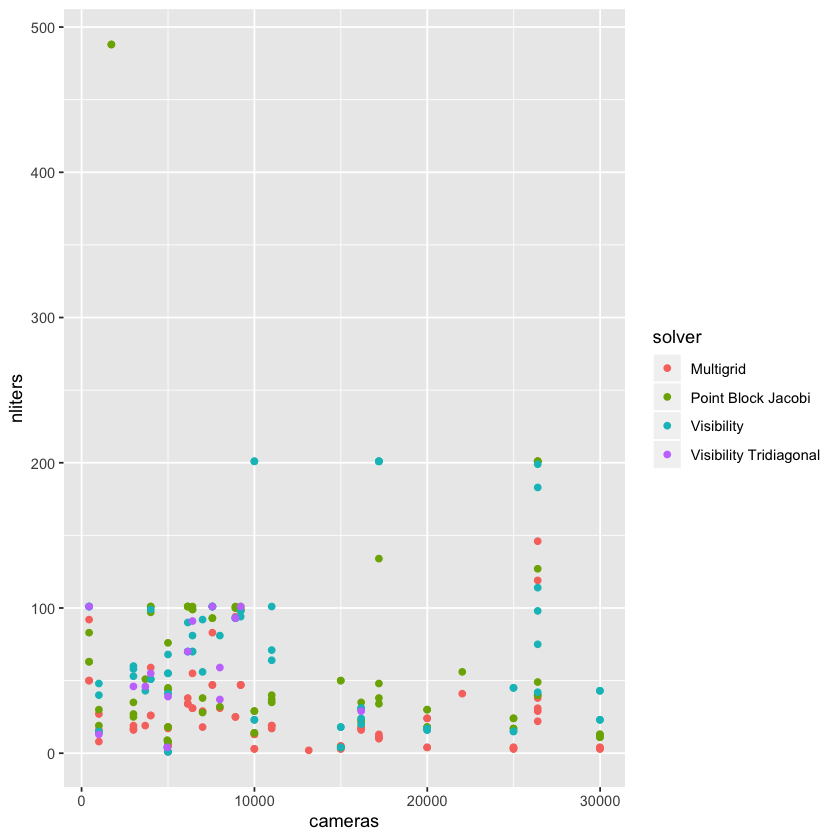

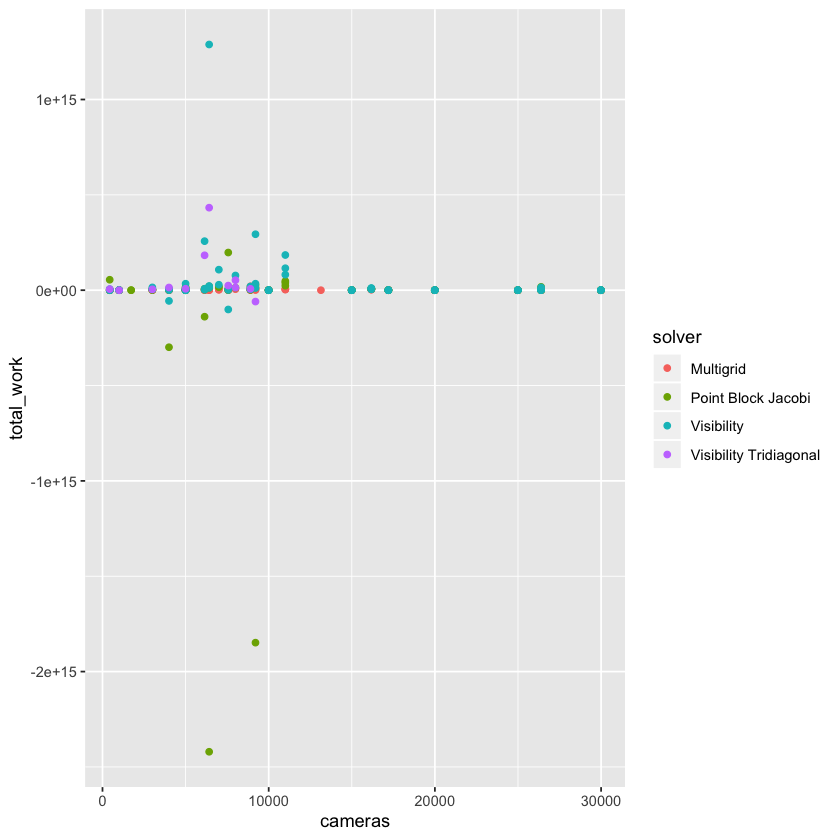

In [47]:
# scaling on all problems
d_agg = d_sametol %>% group_by(solver, bal, eta, robust) %>%
  summarize( cameras=first(cameras), total_work=sum(flops)
           , solve_time=sum(solve_time), setup_time=sum(setup_time)
           , total_time=sum(solve_time)+sum(setup_time), mincost=min(cost)
           , iters=sum(iters), nliters=n())
ggplot(d_agg, aes(x=cameras, y=solve_time+setup_time, color=solver)) +
    geom_point() +
    scale_y_log_eng() +
    labs(color="Preconditioner") +
    xlab("\\# Cameras") +
    ylab("Normalized Time (s/\\# cameras)") +
    theme(legend.position="top")
ggplot(d_agg, aes(x=cameras, color=solver, y=iters)) + geom_point() + scale_y_log_eng()
ggplot(d_agg, aes(x=cameras, color=solver, y=nliters)) + geom_point()
ggplot(d_agg, aes(x=cameras, color=solver, y=total_work)) + geom_point()

[1] "Writing to ../paper/reltime.tex"


pdf 
  2

solver,eta,robust,maxspeedup,avgspeedup,medianspeedup
<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
Multigrid,0.01,FALSE,1.000000,1.0000000,1.0000000
Multigrid,0.01,TRUE,1.000000,1.0000000,1.0000000
Multigrid,0.10,FALSE,1.000000,1.0000000,1.0000000
Multigrid,0.10,TRUE,1.000000,1.0000000,1.0000000
Point Block Jacobi,0.01,FALSE,10.271043,2.8108946,1.3002748
Point Block Jacobi,0.01,TRUE,1.774827,0.9028736,0.8983423
Point Block Jacobi,0.10,FALSE,13.176296,2.6295286,1.7176627
Point Block Jacobi,0.10,TRUE,13.284067,3.3334945,2.3793616
Visibility,0.01,FALSE,15.068514,5.2941358,4.2880297


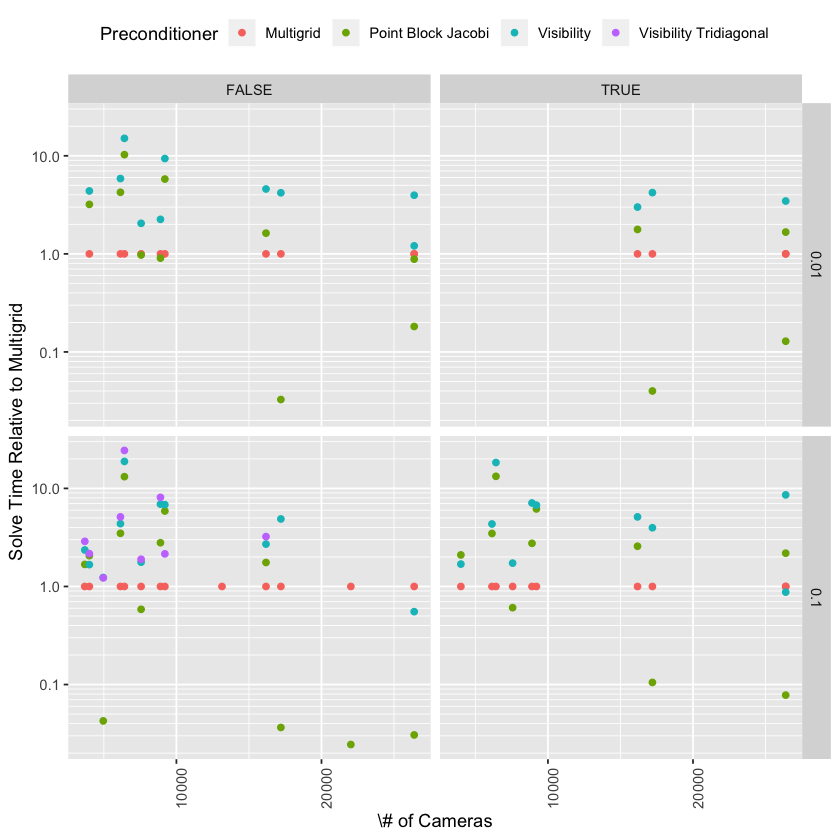

In [48]:
# relative performance
# x = d_agg %>% group_by(solver) %>% group_map(~ unique(.x$bal))
# probs = x[[1]]
# for (i in 2:length(x)) {
#   probs = intersect(probs, x[[i]]);
# }
probs = unique(d_agg[d_agg$solver == "Multigrid",]$bal)
d_rel = d_agg %>% dplyr::filter(#eta == 0.1 & 
                                #robust == FALSE &
                                #cameras < 15000 &
                                cameras > 2500 &
                                is.element(bal, probs) &
                                !grepl("path", bal)) %>%
  group_by(bal, eta, robust) %>% mutate(reltime=total_time/total_time[solver == "Multigrid"])
ggplot(d_rel, aes(x=cameras, y=reltime, color=solver)) + geom_point() +
  scale_y_log_eng() + ylab("Solve Time Relative to Multigrid") +
  xlab("\\# of Cameras") + labs(color = "Preconditioner") +
  theme(legend.position="top") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  facet_grid(rows=vars(eta), cols=vars(robust),# scales="free",
             labeller=as_labeller(function(x)gsub("_", "\\\\char`_", x)))
tikz_file("../paper/reltime.tex", width=6, height=4)
d_rel %>% group_by(solver, eta, robust) %>%
  summarize(maxspeedup=max(reltime),avgspeedup=mean(reltime),medianspeedup=median(reltime))

[1] "Writing to ../paper/nonlinear_cost_vs_iteration.tex"


pdf 
  2

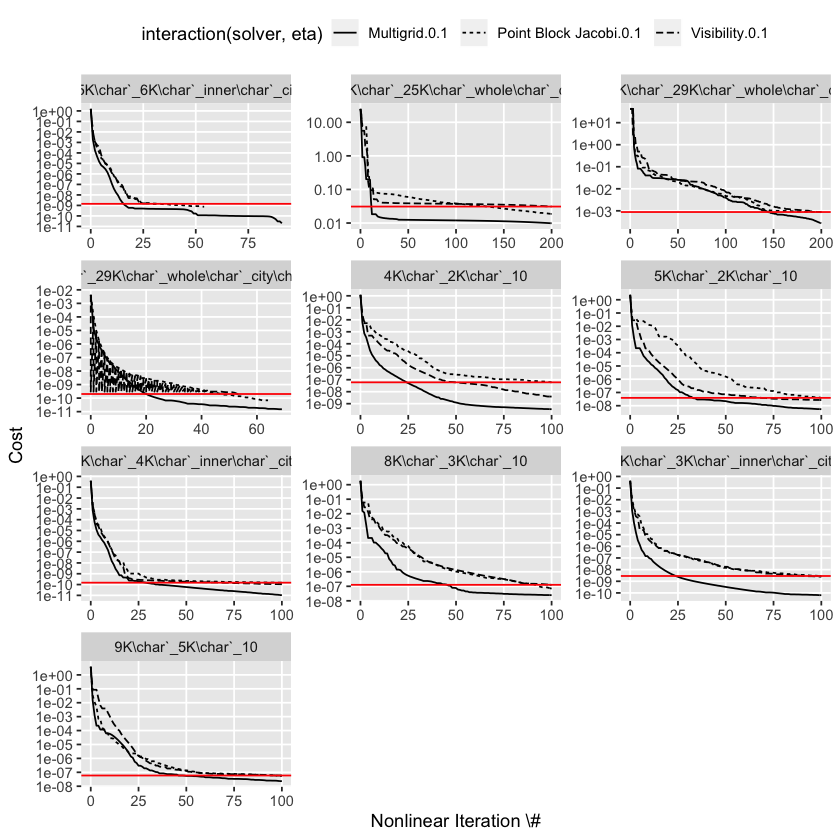

[1] "Writing to ../paper/nonlinear_cost_vs_time.tex"


pdf 
  2

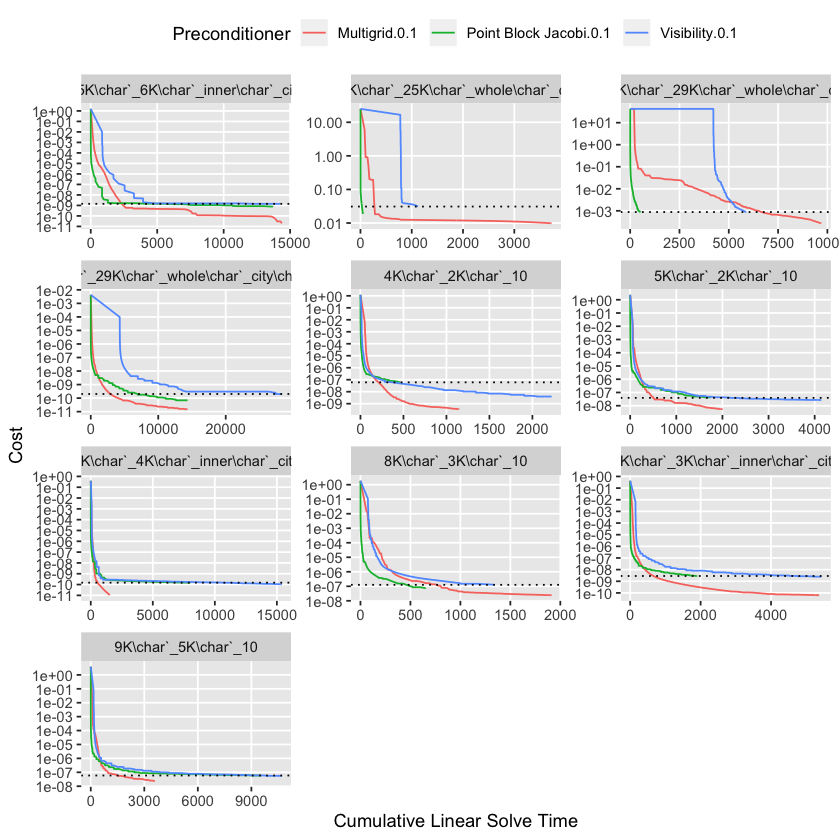

In [56]:
d_combined = ceres %>%
  dplyr::filter(is.element(bal, probs) &
                !grepl("path", bal) &
                cameras > 3000 &
                solver != "SA Multigrid" & 
                eta == 0.1 &
                robust == TRUE
               )
ggplot(d_combined, aes(x=problem, y=costmin, linetype=interaction(solver, eta),
                       #size=setup_time+solve_time
                      )) +
  facet_wrap(vars(bal), scales="free", ncol = 3,
             labeller=as_labeller(function(x)gsub("_", "\\\\char`_", x))) +
  geom_line() +
  theme(panel.grid.minor = element_blank()) +
  scale_y_log_eng() + ylab("Cost") + xlab("Nonlinear Iteration \\#") +
  geom_hline(aes(yintercept=maxmincost), color="red") +
  labs(color="Preconditioner", size="Linear Solve Time") +
  theme(legend.position="top")
tikz_file("../paper/nonlinear_cost_vs_iteration.tex")
                                  
ggplot(d_combined, aes(x=ctime, y=costmin, color=interaction(solver, eta),
                       #size=setup_time+solve_time
                      )) +
  facet_wrap(vars(bal), scales="free", ncol = 3,
             labeller=as_labeller(function(x)gsub("_", "\\\\char`_", x))) +
  geom_line() +
  theme(panel.grid.minor = element_blank()) +
  scale_y_log_eng() + ylab("Cost") + xlab("Cumulative Linear Solve Time") +
  geom_hline(aes(yintercept=maxmincost), linetype=3) +
  labs(color="Preconditioner", size="Linear Solve Time") +
  theme(legend.position="top")
tikz_file("../paper/nonlinear_cost_vs_time.tex")

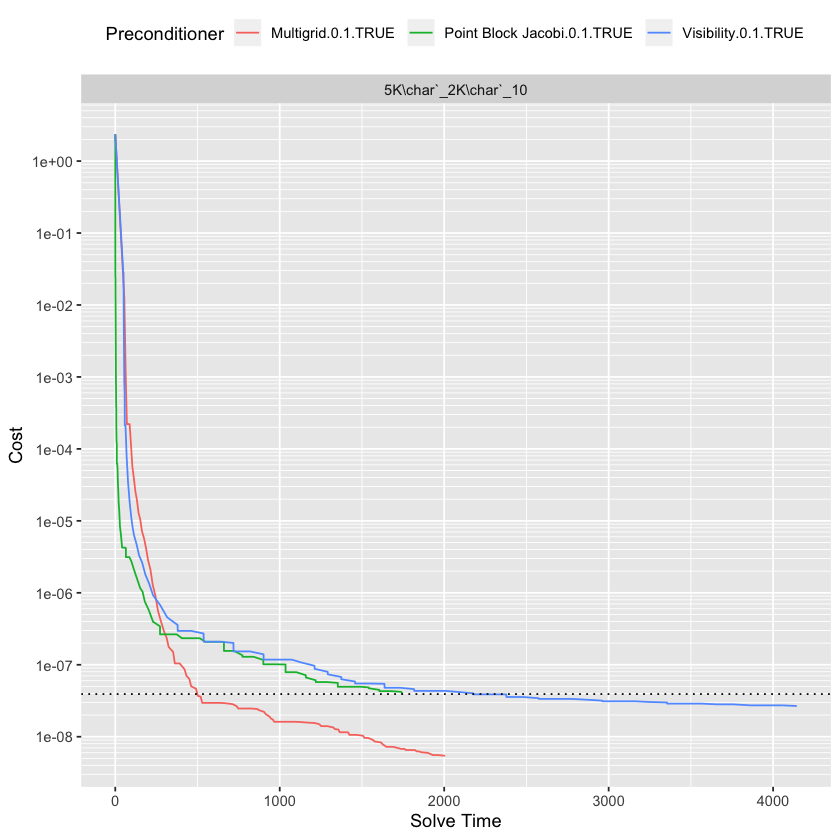

In [50]:
d = ceres[ceres$bal == "5K_2K_10",] %>%
  dplyr::filter(solver != "SA Multigrid" & eta == 0.1 & robust == TRUE) %>%
  group_by(bal, solver, eta, robust) %>% mutate(ctime=cumsum(solve_time)+cumsum(setup_time))
ggplot(d, aes(x=ctime, y=costmin, color=interaction(solver, eta, robust),
                       #size=setup_time+solve_time
                      )) +
  facet_wrap(vars(bal), scales="free", ncol = 3,
             labeller=as_labeller(function(x)gsub("_", "\\\\char`_", x))) +
  geom_line() +
  scale_y_log_eng() +
  #scale_x_log_eng() +
  ylab("Cost") + xlab("Solve Time") +
  geom_hline(aes(yintercept=maxmincost), linetype=3) +
  labs(color="Preconditioner") +
  theme(legend.position="top")

Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "Writing to ../paper/iteration_counts.tex"


Warning message:
“Transformation introduced infinite values in continuous y-axis”


pdf 
  2

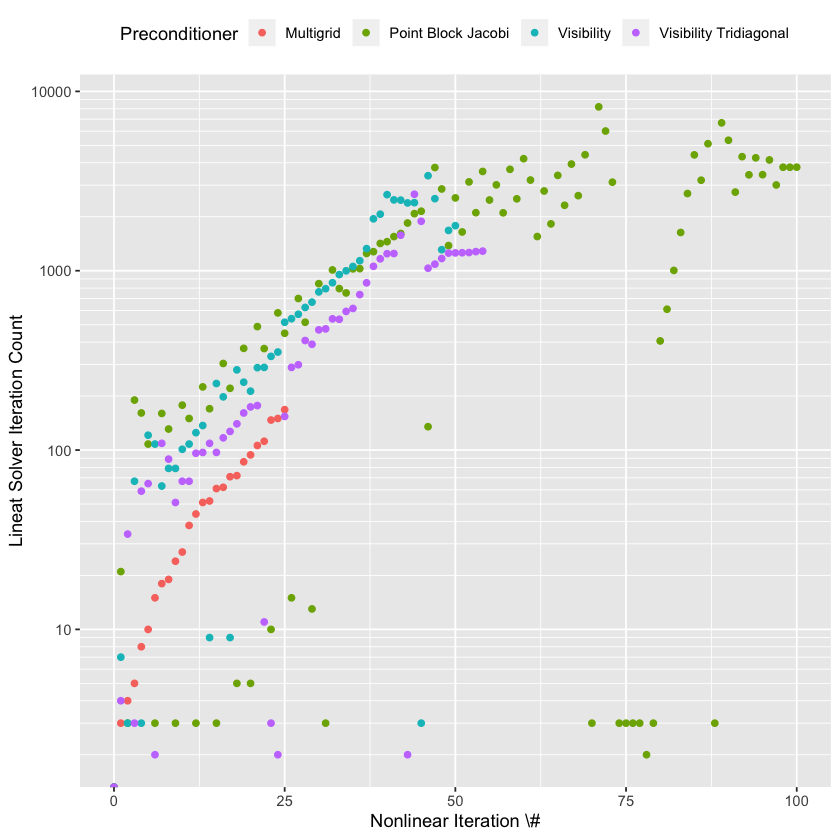

In [51]:
d = d_sametol %>% dplyr::filter(bal == "4K_2K_10" & eta == 0.1 & robust == FALSE)
ggplot(d, aes(x=problem, y=iters, color=solver)) +
  geom_point() +
  scale_y_log_eng() +
  labs(color="Preconditioner", x="Nonlinear Iteration \\#", y="Lineat Solver Iteration Count") +
  theme(legend.position="top")
tikz_file("../paper/iteration_counts.tex")

bal,solver,total_time,solve_time,setup_time,cameras
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
11K_path,Multigrid,3617.31745,3326.27945,291.0380000,11000
11K_path,Point Block Jacobi,23631.53770,23627.45096,4.0867360,11000
11K_path,Visibility,90407.09264,89974.95069,432.1419500,11000
1K_path,Multigrid,123.60230,49.89715,73.7051500,1000
1K_path,Point Block Jacobi,69.23114,68.93866,0.2924806,1000
1K_path,Visibility,174.53094,169.46243,5.0685048,1000
3K_path,Multigrid,492.18503,387.11140,105.0736300,3000
3K_path,Point Block Jacobi,843.76970,842.94459,0.8251100,3000
3K_path,Visibility,3306.45111,3281.38725,25.0638660,3000


[1] "Writing to ../paper/scaling_test.tex"


pdf 
  2

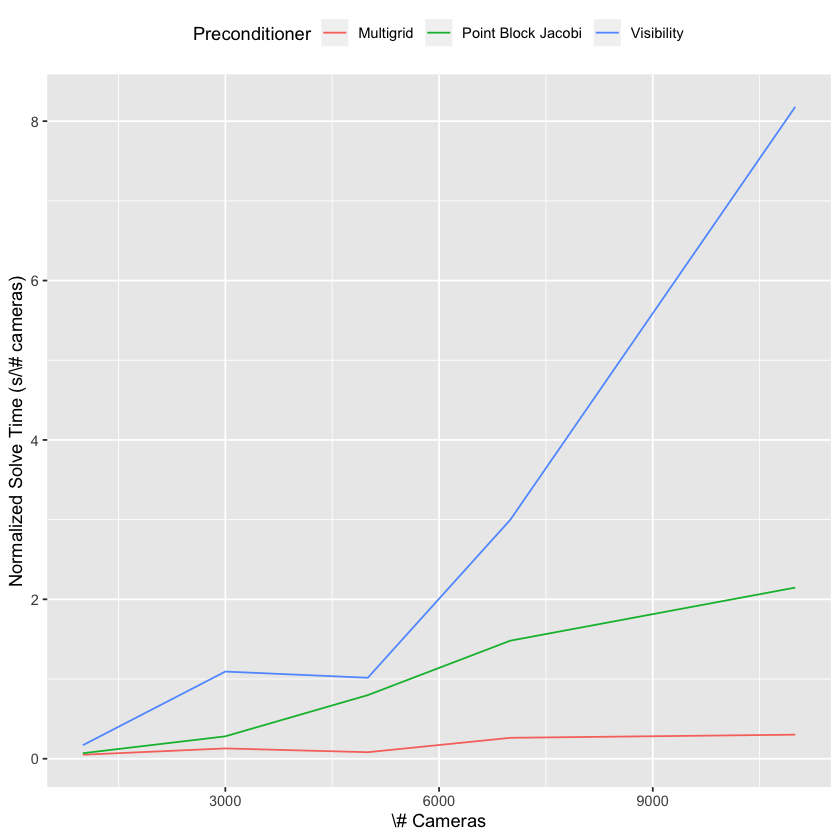

In [52]:
d = d_sametol %>% dplyr::filter(grepl("path", bal) & !grepl("long_path", bal) & eta == 0.1 & robust == TRUE)
maxmincost = d %>% group_by(bal, solver) %>%
  summarize(mincost=min(cost)) %>% ungroup() %>% summarize(maxmincost=max(mincost))
path_sametol = d %>% group_by(bal, solver) %>%
    group_modify(~ .x[.x$problem <= min(.x$problem[.x$cost <= .x$maxmincost]),]) %>%
    summarize(total_time=sum(setup_time)+sum(solve_time), solve_time=sum(solve_time),
              setup_time=sum(setup_time), cameras=first(cameras))
path_sametol
# summary(lm(total_time ~ cameras, d_path[d_path$solver == "multigrid",]))
# summary(lm(log(total_time) ~ cameras, d_path[d_path$solver == "pbjacobi-implicit",]))
# summary(lm(log(total_time) ~ cameras, d_path[d_path$solver == "visibility",]))

# TODO: should use nnz here
ggplot(path_sametol, aes(x=cameras, color=solver)) +
  geom_line(aes(y=solve_time/cameras)) +
  #geom_line(aes(y=setup_time/cameras, linetype="Setup")) +
  #geom_line(aes(y=solve_time/cameras, linetype="Solve")) +
  #geom_line(aes(y=total_time/cameras, linetype="Total")) +
  #geom_line() +
  #scale_y_log_eng() +
  ylab("Normalized Solve Time (s/\\# cameras)") +
  xlab("\\# Cameras") +
  labs(color="Preconditioner") +
  theme(legend.position="top")
tikz_file("../paper/scaling_test.tex", width=5, height=5)

In [53]:
# per iteration solve times

Warning message:
“Transformation introduced infinite values in continuous y-axis”


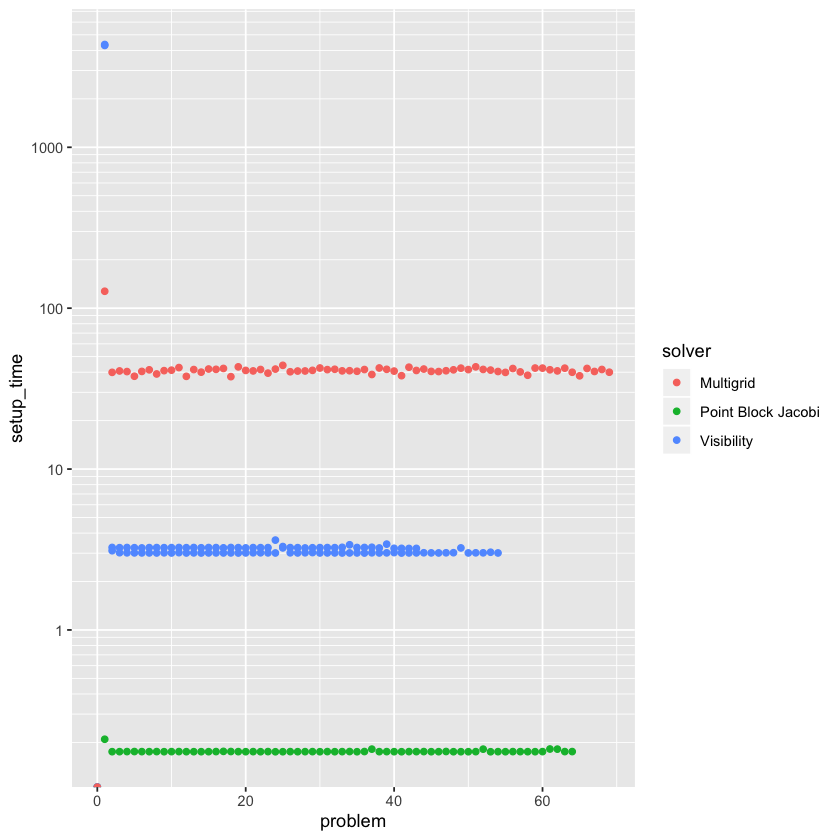

In [54]:
d = ceres %>% dplyr::filter(bal == "26K_29K_whole_city_hard" & eta == 0.1 & robust == TRUE)
ggplot(d, aes(x=problem, y=setup_time, color=solver)) + geom_point() + scale_y_log_eng()

In [55]:
#ceres %>% dplyr::filter(robust == TRUE) #%>% group_by(bal, solver) %>% mutate(reliters=iters/iters[robust == TRUE])
d_agg %>% dplyr::filter(eta == 0.1) %>% group_by(solver,bal) %>% transmute(eta=eta, cameras=cameras, robust=robust, iters=iters) %>% spread(robust, iters)

solver,bal,eta,cameras,FALSE,TRUE
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Multigrid,10K_long_path,0.1,9996,NA,24
Multigrid,10K_long_path_drift,0.1,9996,NA,24
Multigrid,11K_path,0.1,11000,7161,10232
Multigrid,13K_3K_10,0.1,13142,3,NA
Multigrid,15K_6K_inner_city,0.1,16175,1307,1307
Multigrid,15K_long_path,0.1,14994,NA,4
Multigrid,15K_long_path_drift,0.1,14994,NA,4
Multigrid,17K_25K_whole_city,0.1,17201,23,26
Multigrid,1K_path,0.1,1000,66,1734
